## Simulate the runout of a landslide on a laboratory flume

### import necessary packages and components

In [21]:
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
import numpy as np

from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, FlowDirectorMFD
from landlab import imshowhs_grid
from landlab.components.mass_wasting_router import MassWastingRunout

### define the flume dimensions, landslide (regolith) and MassWastingRunout parameters Sc, qsi and k

In [22]:
# add option of have just 1 flume or 2 combined flumes

# Define the flume
dxdy = 0.075
rows = 15 #
columns = 15 # must be odd number
ls_width = 3 # number of cells wide, must be odd number
ls_length = 5 # number of cells long
slope_above_break = 0.6
slope_below_break = 0.001
#slope_break1 = 0.25 # ratio of flume 1 to place the slope break
slope_break = 0 # ratio of flume 2 to place the slope break
soil_thickness = .05
Dp = 0.002 # particle diameter

# run parameters
qsc = 0.01 # pick qsc
Sc = 0.05 # critical slope
k = 0.001 # coeficient multiplied by qsc to determine equivlanet alpha

### create the flume

#### a tool for making the laboratory flume

In [23]:
def flume_maker(rows = 5, columns = 3, slope_above_break =.5, slope_below_break =.05, slope_break = 0.7, ls_width = 1, ls_length = 1, dxdy= 10):
    """   
    Parameters
    ----------
    rows : integer
        number of rows in model domain. First and last row are used as boundaries
    columns : integer
        number of columns in domain. First and last column are used as boundaries
    slope_above_break : float
        slope of flume above break [m/m]
    slope_below_break : float
        slope of flume below break [m/m]
    slope_break : float
        ratio of length the slope break is placed, measured from the outlet
        slope break will be placed at closest node to slope_break value
    ls_width : odd value, integer
        width of landslide in number of cells, , must be <= than rows-2
    ls_length : integer
        length of landslide in number of cells, must be <= than rows-2
    dxdy : float
        side length of sqaure cell, [m]. The default is 10.

    Returns
    -------
    mg : raster model grid
        includes the field topographic__elevation
    lsn : np array
        0-d array of node id's that are the landslide
    pf : np array
        0-d array of node id's along the center of the flume. Used for profile
        plots.
    cc : np array
        0-d array of landslide node column id's'
    """
    r = rows; #rows
    c = columns; # columns
    sbr_r = slope_break; # 
    if ls_width == 1:
        cc = int(c/2)+1
    elif (ls_width <= c) and (ls_width%2 == 1):
        cc = []
        for i in range(ls_width):
            dif = -((ls_width)%2)+i
            cc.append(int(c/2)+dif+1)
        cc = np.array(cc)
    mg = RasterModelGrid((r,c+2),dxdy)
    ycol = np.reshape(mg.node_y,(r,c+2))[:,0]
    yn = np.arange(r)
    yeL = []
    sb = (mg.node_y.max()*sbr_r)
    sbr = yn[ycol>=sb].min()
    sb = ycol[sbr]
    for y in ycol:
        if y<sb:
            #ye = 0 #flat
            ye = y*slope_below_break
        else:
            # hillslope
            ye = (y-sb)*slope_above_break+sb*slope_below_break
        yeL.append(ye)
    dem = np.array([yeL,]*c).transpose()
    wall = np.reshape(dem[:,0],(len(dem[:,0]),1))+2*dxdy
    dem = np.concatenate((wall,dem,wall),axis =1)
    dem = np.hstack(dem).astype(float)
    _ = mg.add_field('topographic__elevation',
                        dem,
                        at='node')
    # profile nodes, for profile plot
    if ls_width == 1:
        pf = mg.nodes[:,cc]
    elif ls_width > 1:
        pf = mg.nodes[:,int(c/2)+1]
    # landslide nodes
    lsn = mg.nodes[-(ls_length+1):-1,cc]
    return mg, lsn, pf, cc

In [24]:
pi = 1 # plot index

pdir = "D:/UW_PhD/PreeventsProject/Paper_2_MWR/Landlab_Development/mass_wasting_runout/development_plots/tests_version2/"

mg1, lsn1, pf1, cc1 = flume_maker(rows = rows, columns = columns, slope_above_break = slope_above_break
                              , slope_below_break = slope_below_break, slope_break = slope_break/2, ls_width = ls_width, ls_length = ls_length, dxdy = dxdy)


mg2, lsn2, pf2, cc2 = flume_maker(rows = rows, columns = columns, slope_above_break = slope_above_break
                              , slope_below_break = slope_below_break, slope_break = slope_break, ls_width = ls_width, ls_length = ls_length, dxdy = dxdy)

mg = RasterModelGrid((rows*2,columns+2),dxdy)
#
t1 = mg1.at_node['topographic__elevation'] + mg2.at_node['topographic__elevation'].max()-dxdy
t2 = mg2.at_node['topographic__elevation']

topo = np.concatenate((t2,t1))
_ = mg.add_field('topographic__elevation',
                    topo,
                    at='node')

nn = len(mg2.node_x)

pf = np.concatenate((pf2,np.array(pf1+nn).astype(int)))

cc = cc1
lsn = lsn1+nn


mg.at_node['topographic__elevation'] = mg.at_node['topographic__elevation']+dxdy

dem = mg.at_node['topographic__elevation']


# mass wasting ide
mg.at_node['mass__wasting_id'] = np.zeros(mg.number_of_nodes).astype(int)
mg.at_node['mass__wasting_id'][lsn] = 1

# mg.at_node['topographic__elevation'][55] = mg.at_node['topographic__elevation'][55]+1.3

# domain for plots
xmin = mg.node_x.min(); xmax = mg.node_x.max(); ymin = mg.node_y.min(); ymax = mg.node_y.max()

# set boundary conditions, add flow direction
mg.set_closed_boundaries_at_grid_edges(True, True, True, True) #close all boundaries


mg.set_watershed_boundary_condition_outlet_id(cc,dem)
    
mg.at_node['node_id'] = np.hstack(mg.nodes)

# flow directions
fa = FlowAccumulator(mg, 
                      'topographic__elevation',
                      flow_director='FlowDirectorD8')
fa.run_one_step()

# hillshade for plots
mg.at_node['hillshade'] = mg.calc_hillshade_at_node(elevs=dem, alt=37., az=210.)


# soil thickness
thickness = np.ones(mg.number_of_nodes)*soil_thickness
mg.add_field('node', 'soil__thickness',thickness)

# round out lower part of failure surface
mg.at_node['soil__thickness'][lsn[0][0:]] = soil_thickness/2


# set particle diameter
mg.at_node['particle__diameter'] = np.ones(len(mg.node_x))*Dp


# # no soil thickness
# thickness = np.zeros(mg.number_of_nodes)*soil_thickness
# mg.add_field('node', 'soil__thickness',thickness)
# mg.at_node['soil__thickness'][lsn] = soil_thickness*np.ones(len(lsn))

# copy of initial topography
DEMi = mg.at_node['topographic__elevation'].copy()


In [25]:
#%% Add multiflow direction

# run flow director, add slope and receiving node fields
mg.delete_field(loc = 'node', name = 'flow__sink_flag')
mg.delete_field(loc = 'node', name = 'flow__link_to_receiver_node')
mg.delete_field(loc = 'node', name = 'flow__receiver_node')
mg.delete_field(loc = 'node', name = 'topographic__steepest_slope')

# run flow director, add slope and receiving node fields
fd = FlowDirectorMFD(mg, diagonals=True,
                      partition_method = 'square_root_of_slope')
# fd = FlowDirectorDINF(mg)
# fd = FlowDirectorD8(mg)
fd.run_one_step()


### take a look at the flume, and location of the landslide on the flume

Zmin0.075, Zmax1.56


<Axes: xlabel='Easting', ylabel='Northing'>

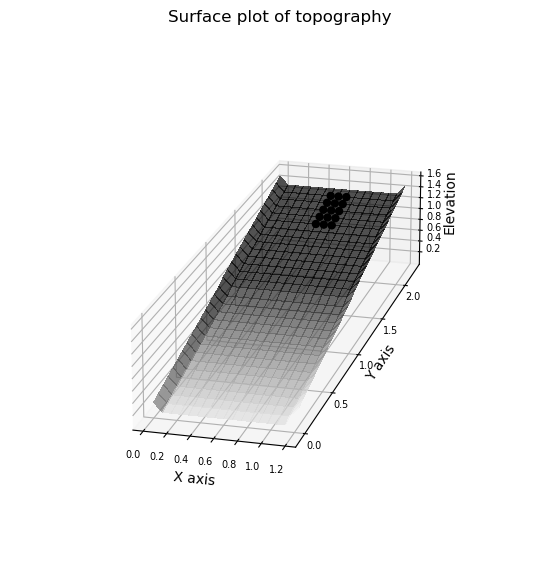

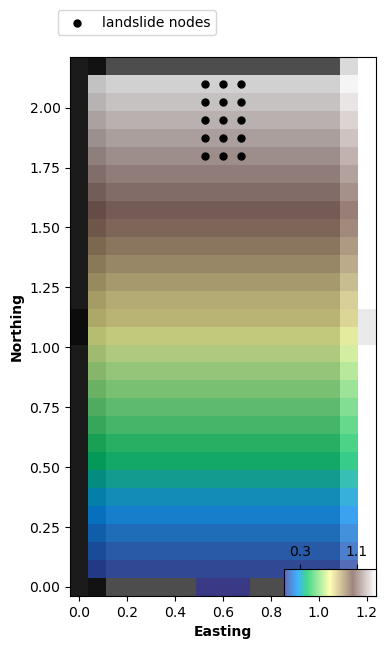

In [26]:
# borrow the plotting routine from the flow-director notebookks to make a 3d plot of our surface.
# import plotting tools
def surf_plot(mg,
              surface='topographic__elevation',
              title='Surface plot of topography'):

    fig = plt.figure(figsize = (7,7))
    ax = fig.add_subplot(projection='3d')
    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    print('Zmin{}, Zmax{}'.format(Z.min(), Z.max()))
    color = cm.gray_r((Z - Z.min())*2 / (Z.max() - Z.min()))
    surf = ax.plot_surface(mg.x_of_node.reshape(mg.shape),
                           mg.y_of_node.reshape(mg.shape),
                           Z,
                           rstride=1,
                           cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False,
                          alpha = 0.67)
    ax.view_init(elev=20, azim=-75)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')

    plt.title(title)
    ax.set_box_aspect([.30, 1, 0.2])
    ax.tick_params(axis = 'both', which = 'major', labelsize = 7)
    return ax

plt.show()

    
# 3d view
ax = surf_plot(mg)
ax.scatter(mg.node_x[lsn], mg.node_y[lsn], mg.at_node['topographic__elevation'][lsn], 
       marker = '.', color = 'k',alpha = 1, s = 100)

# 2d view
plt.figure(figsize = (7,7))
plt.scatter(mg.node_x[lsn], mg.node_y[lsn],
            marker = '.', color = 'k',alpha = 1, 
            s = 100, label = 'landslide nodes')
plt.legend(bbox_to_anchor=(.5, 1.1))
imshowhs_grid(mg,
            'topographic__elevation',
            drape1 = 'topographic__elevation',
            cmap = 'terrain',
            allow_colorbar=True,
            plot_type=  "Drape1",
            alpha = 0.75,
            altdeg=37., azdeg=210)


Zmin0.0, Zmax0.78


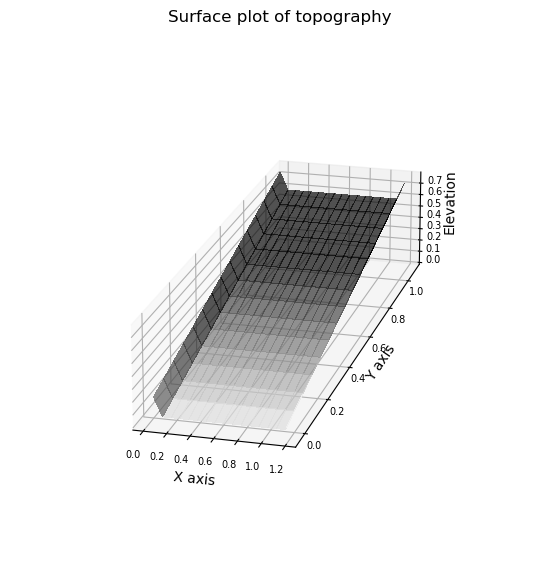

In [27]:
ax = surf_plot(mg1)

In [8]:
mg.node_y.max()

2.1749999999999998

### now set up an instance of MassWastingRuntout to landslide and runout on the flume

In [9]:
mw_dict = {'critical slope':[Sc], 'threshold flux':qsc,
            'scour coefficient':k, 'effective particle diameter':Dp}
MWRu = MassWastingRunout(mg, mw_dict, effective_qsi = False, save = True, grain_shear = False, settle_deposit = True)

### run the instance of MassWastingRunout

In [10]:
start_time = time.time()
MWRu.run_one_step(run_id = 0)

20


### view runout extent

Zmin0.075, Zmax0.9310499999999999


<Axes: xlabel='Easting', ylabel='Northing'>

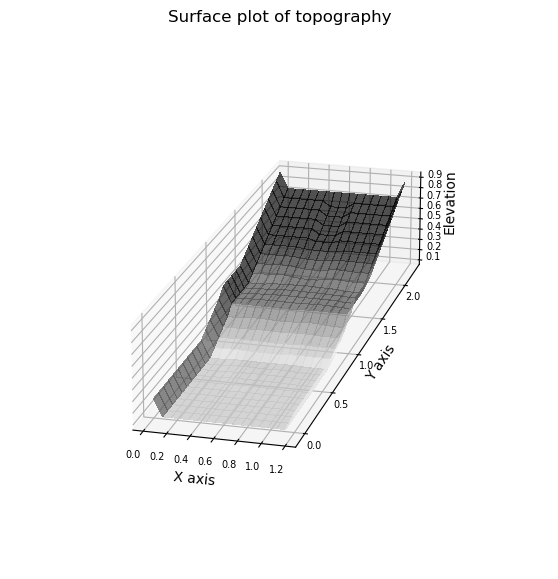

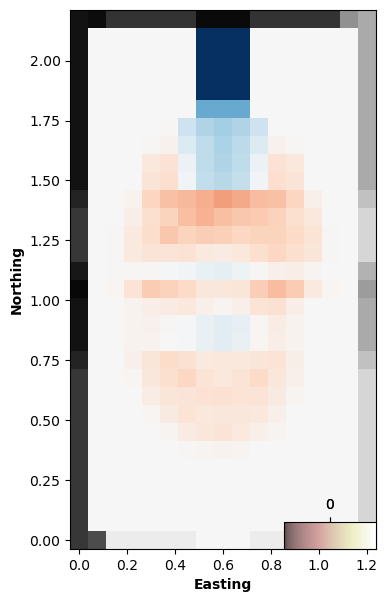

In [11]:
# change in topography is small relative to dimensions of flume

mg.at_node['dem_dif_o'] = mg.at_node['topographic__elevation']-mg.at_node['topographic__initial_elevation']

# 3d view
surf_plot(mg)

#2d view
plt.figure(figsize = (7,7))
imshowhs_grid(mg,
            'topographic__elevation',
            drape1 = 'topographic__elevation',
            drape2 = 'dem_dif_o',
            cmap2 = 'RdBu_r',
            allow_colorbar=True,
            plot_type=  "Drape2",
            limits = (-0.05,0.05),
            alpha = 0.75,
            altdeg=37., azdeg=210)

In [12]:
### view repeat images of runout process

<Figure size 1200x1200 with 0 Axes>

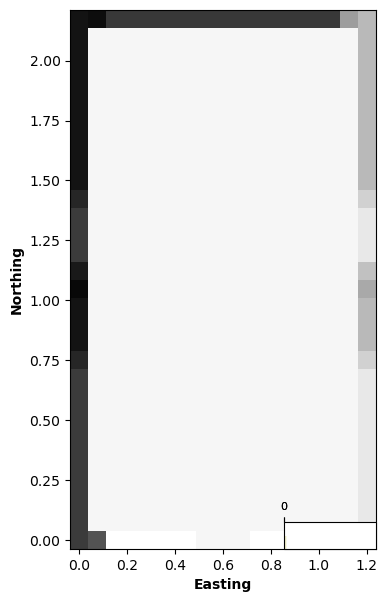

<Figure size 1200x1200 with 0 Axes>

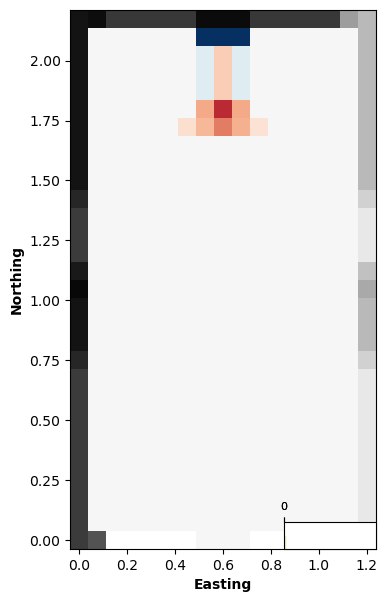

<Figure size 1200x1200 with 0 Axes>

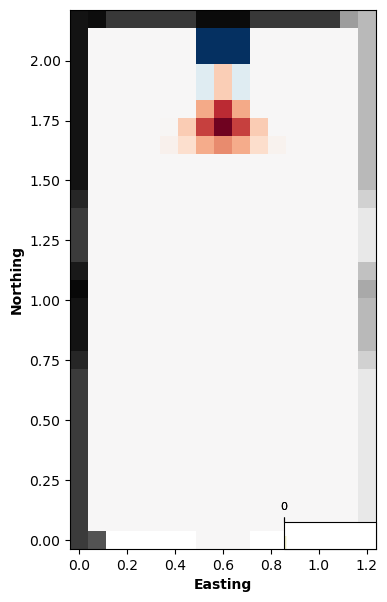

<Figure size 1200x1200 with 0 Axes>

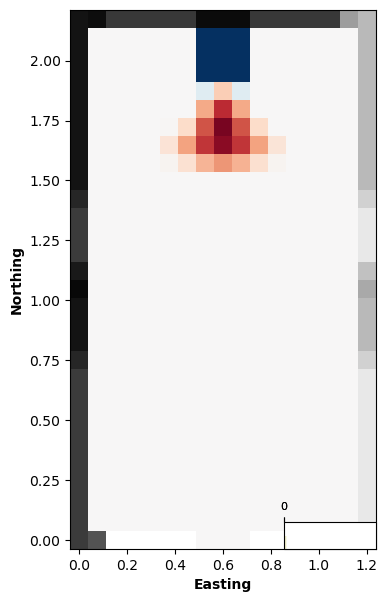

<Figure size 1200x1200 with 0 Axes>

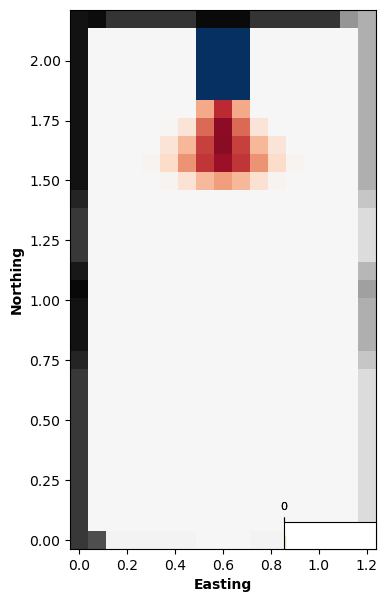

<Figure size 1200x1200 with 0 Axes>

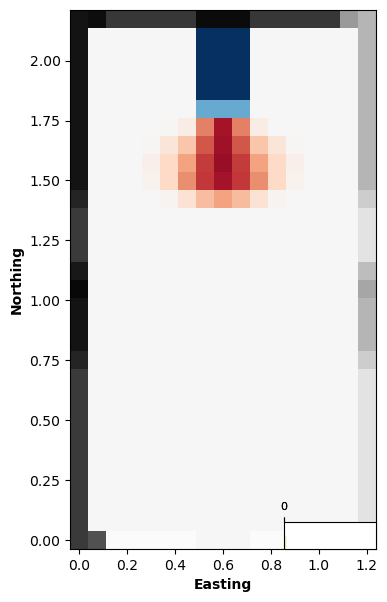

<Figure size 1200x1200 with 0 Axes>

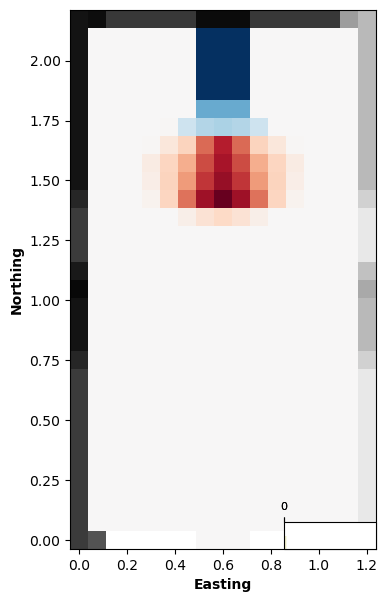

<Figure size 1200x1200 with 0 Axes>

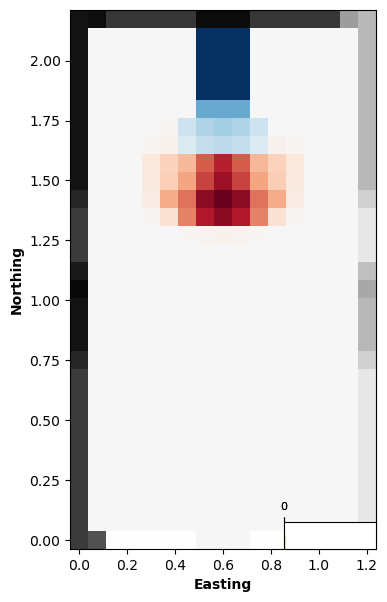

<Figure size 1200x1200 with 0 Axes>

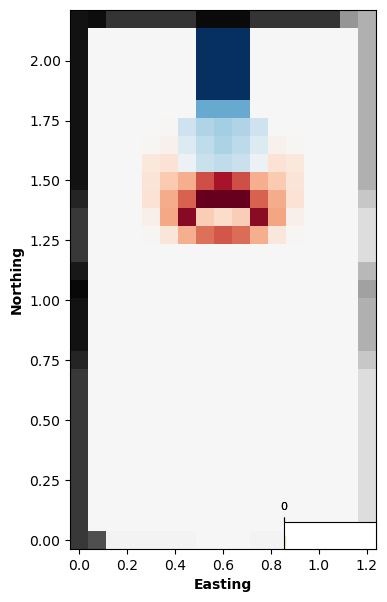

<Figure size 1200x1200 with 0 Axes>

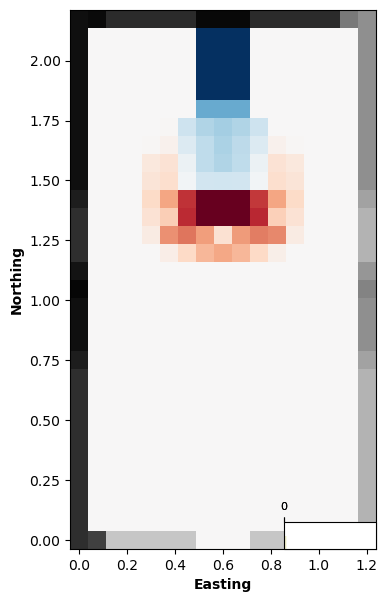

<Figure size 1200x1200 with 0 Axes>

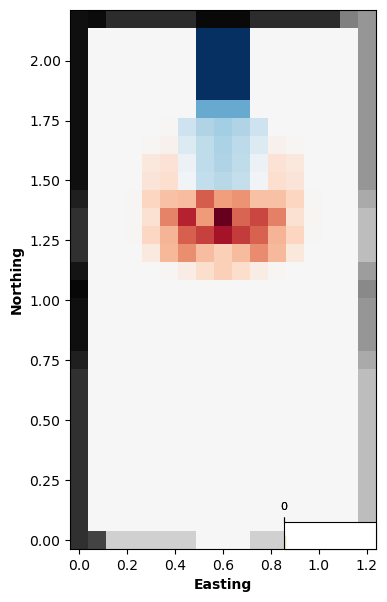

<Figure size 1200x1200 with 0 Axes>

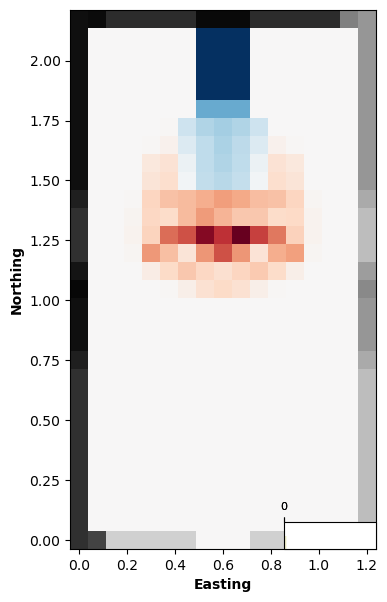

<Figure size 1200x1200 with 0 Axes>

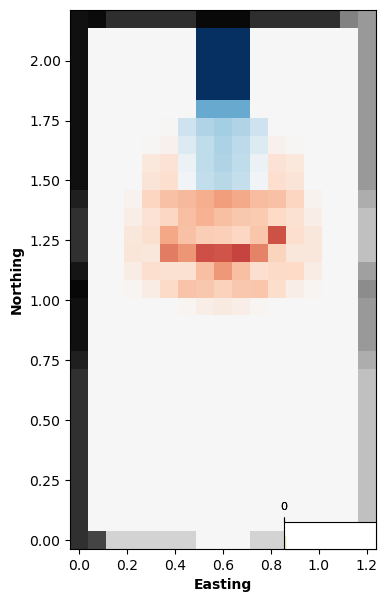

<Figure size 1200x1200 with 0 Axes>

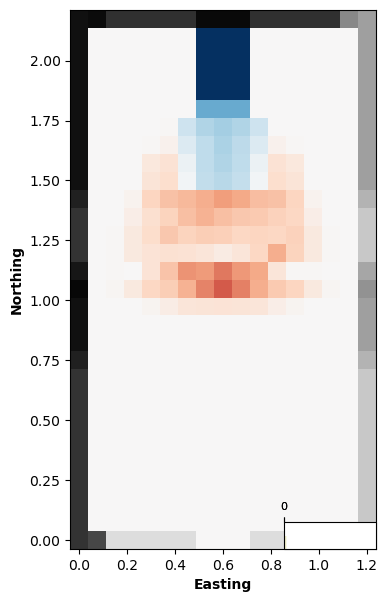

<Figure size 1200x1200 with 0 Axes>

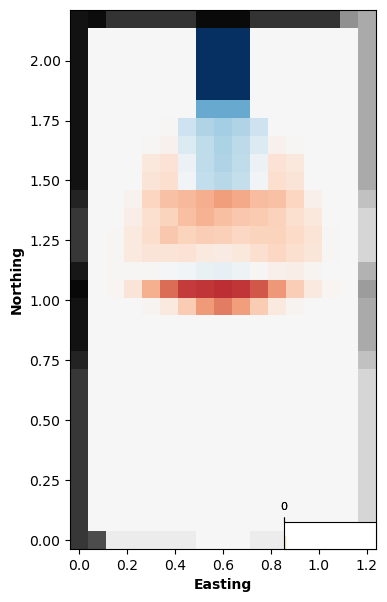

<Figure size 1200x1200 with 0 Axes>

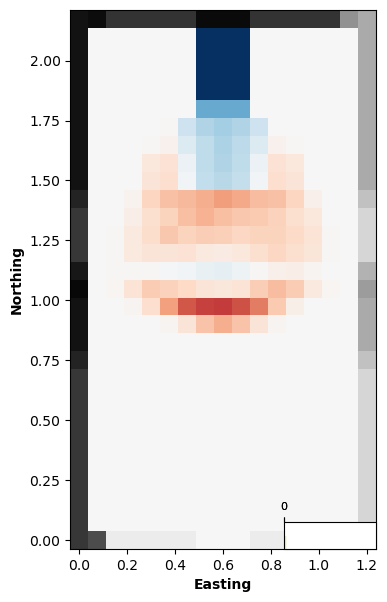

<Figure size 1200x1200 with 0 Axes>

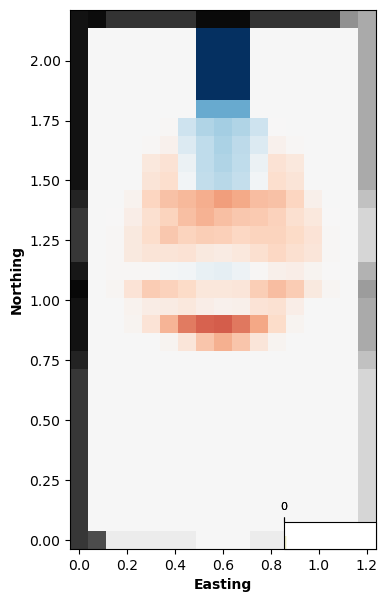

<Figure size 1200x1200 with 0 Axes>

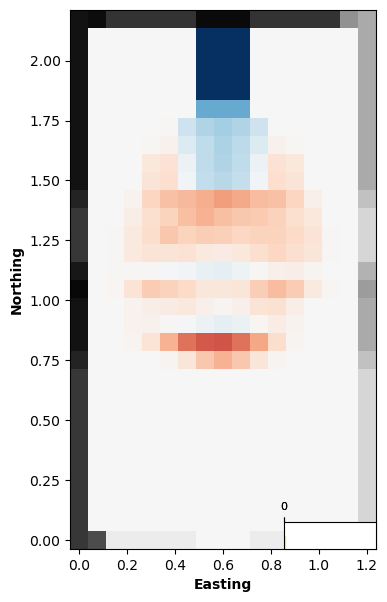

<Figure size 1200x1200 with 0 Axes>

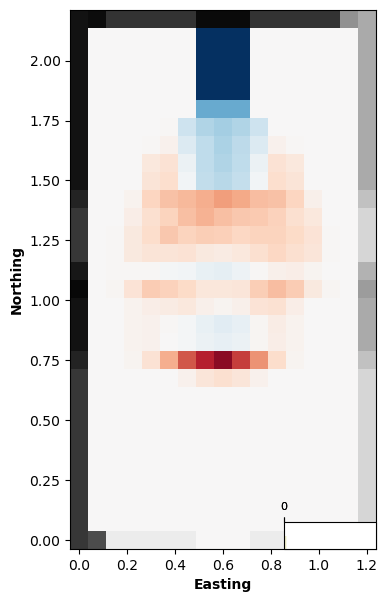

<Figure size 1200x1200 with 0 Axes>

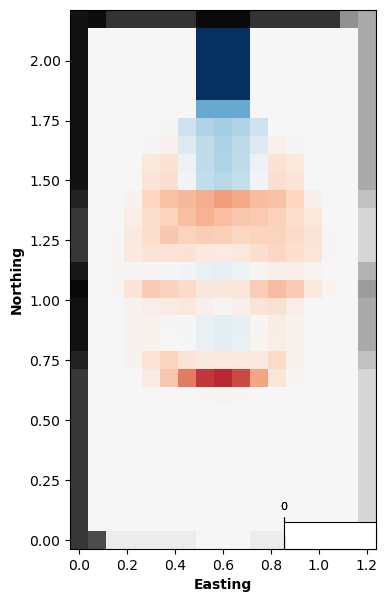

<Figure size 1200x1200 with 0 Axes>

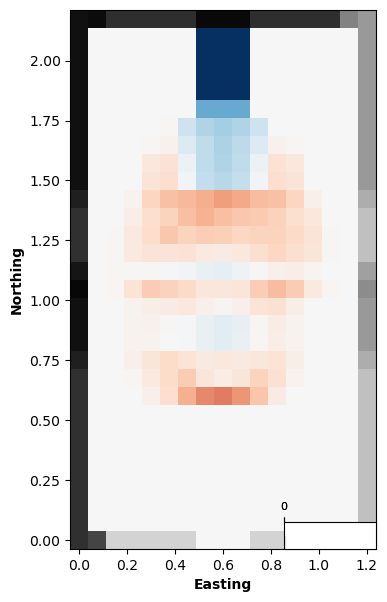

<Figure size 1200x1200 with 0 Axes>

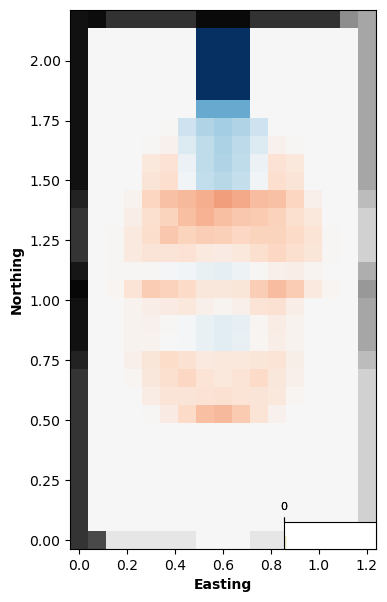

<Figure size 1200x1200 with 0 Axes>

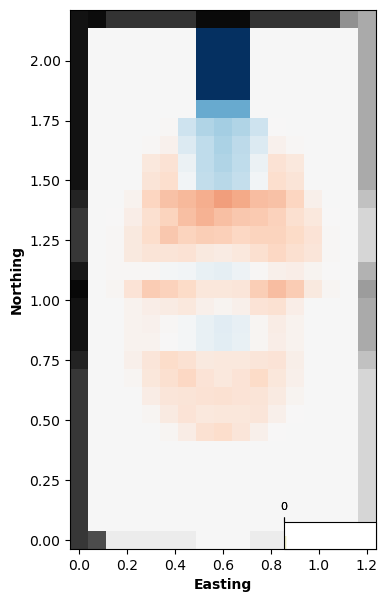

In [13]:
# plot how DEM changes
for i in np.arange(0,len(MWRu.mw_ids)):
    for c in MWRu.runout_evo_maps[i].keys():                  
        plt.figure('topography'+str(c)+str(i),figsize=(12, 12))
        mg.at_node['topographic__elevation'] = MWRu.runout_evo_maps[i][c]
        mg.at_node['df_topo'] = MWRu.runout_evo_maps[i][c]-mg.at_node['topographic__initial_elevation']
        field = "node_id"
        plt.figure(figsize = (7,7))
        
        imshowhs_grid(mg,
                    'topographic__elevation',
                    drape1 = 'topographic__elevation',
                    drape2 = 'df_topo',  
                    cmap2 = 'RdBu_r',
                    allow_colorbar=True,
                    plot_type=  "Drape2",
                    limits = (-0.05,0.05),
                    alpha = 0.75,
                    altdeg=37., azdeg=210)
        
        plt.xticks(fontsize= 8 )
        plt.yticks(fontsize= 8 )
        plt.xlim([xmin*.8,xmax*1.2]); plt.ylim([ymin*.3,ymax])
        plt.show()

        if c >50:
            break